## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [ ]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, cohen_kappa_score
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC


In [ ]:
myData = pd.read_csv("https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1")
myData = myData.dropna()
myData.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease


In [ ]:
myData['diagnosis'] = np.where(myData['diagnosis'] == 'Disease', 0, 1)
myData

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,1
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,0
2,Miles Wolf,62,0,3,130,263,1,97,1
3,Mikaila Block,43,1,1,115,303,1,181,0
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,0
...,...,...,...,...,...,...,...,...,...
199,Bridgett Franecki,55,0,1,128,205,2,130,1
200,Mr. Foster Zieme,51,1,3,94,227,1,154,0
201,Lashanda Hagenes,42,1,2,120,295,1,162,0
202,Levern Trantow III,35,0,1,138,183,1,182,0


In [ ]:
myData['diagnosis'] = myData['diagnosis'].astype('category')

In [ ]:
X = myData[['age','chol']]
y = myData["diagnosis"]

In [ ]:

ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=object))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [ ]:
log_reg_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("log_reg", LogisticRegression())
    ]
).set_output(transform="pandas")

params = {'log_reg__C': [0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(
    log_reg_pipeline,
    params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X, y)

grid_search.best_params_['log_reg__C']


0.01

In [ ]:
log_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("log", LogisticRegression(C=.01))
    ]
).set_output(transform="pandas")

In [ ]:
log_pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a1abd2fdf60>)])),
                ('log', LogisticRegression(C=0.01))])

In [ ]:
log_model = log_pipeline.named_steps["log"]
names = X.columns
coefficients = log_model.coef_[0]
coef_df = pd.DataFrame(coefficients.T, index=names)
coef_df


,0
age,0.045615
chol,0.001851


In [ ]:
intercept = log_model.intercept_[0]
age_mean = X["age"].mean()
age_std = X["age"].std()
scaled_age = (55 - age_mean) / age_std

In [ ]:
df = pd.DataFrame({
    'age': [55] * 1000,
    'chol': range(1, 1001)
})


In [ ]:
XT = df[['age','chol']]

In [ ]:
y_pred = log_pipeline.predict_proba(XT)[:, 1]

In [ ]:
dataT = pd.DataFrame({
    'Cholesterol': XT['chol'],
    'Predicted_Label': y_pred
})


In [ ]:
print(log_pipeline.classes_)

[0 1]


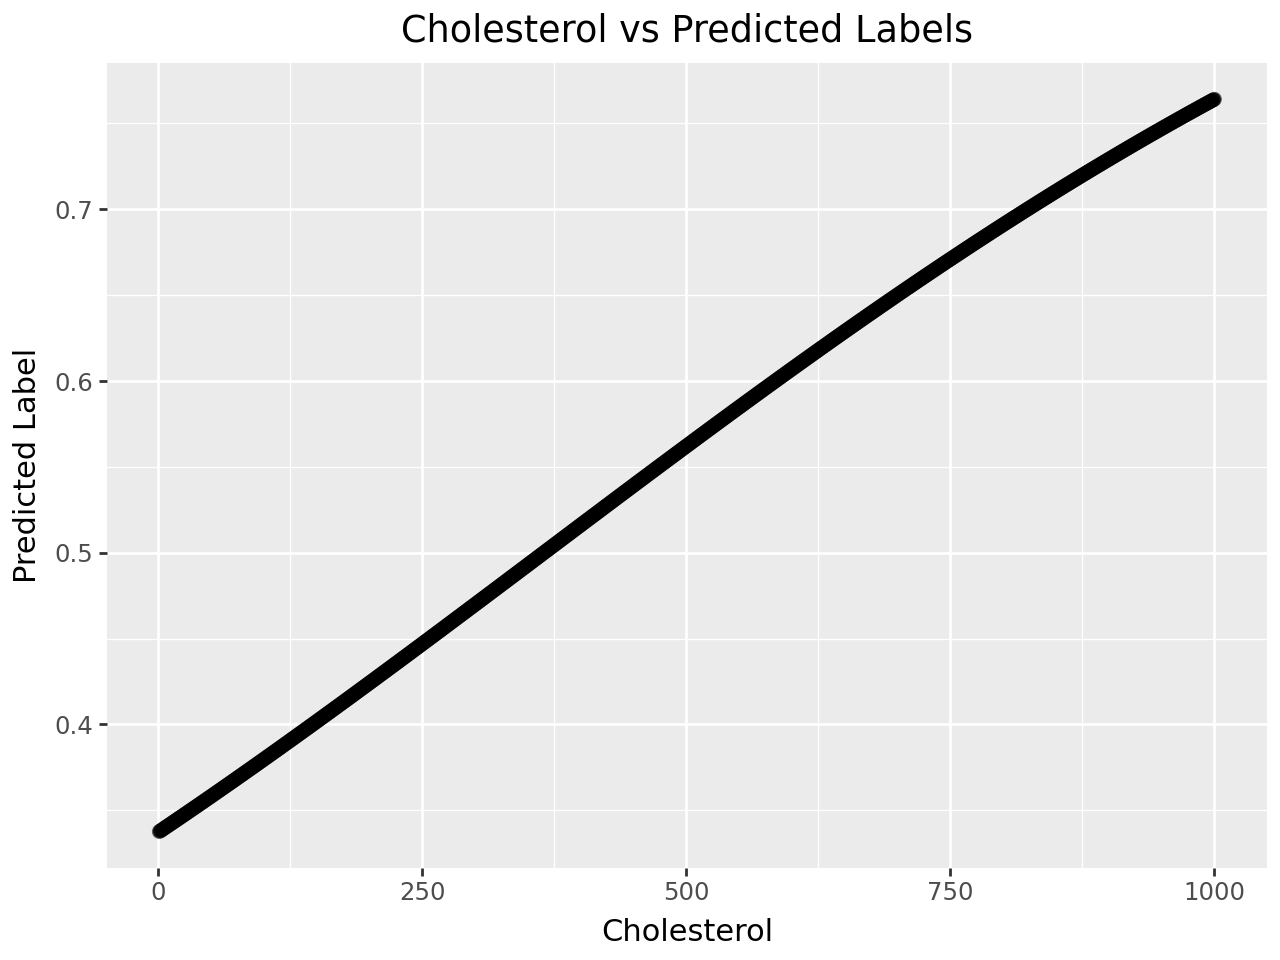

In [ ]:
(ggplot(dataT, aes(x='Cholesterol', y='Predicted_Label')) +
    geom_point(alpha=0.6, size=2) +
    labs(
        title="Cholesterol vs Predicted Labels",
        x="Cholesterol",
        y="Predicted Label"
    )
)

In [ ]:
threshold = 0.5
threshold = np.log(threshold / (1 - threshold))
agec	= 0.045615
cholc =	0.001851
age=55

In [ ]:
val = (threshold - intercept - agec * 55) / cholc
val

384.0370936828083

For a 55 yr old they would need a cholesterol reading over 384




90%

In [ ]:
threshold = 0.9
threshold = np.log(threshold / (1 - threshold))
agec	= 0.045615
cholc =	0.001851
age=55


In [ ]:
val = (threshold - intercept - agec * 55) / cholc
val

312.70072786016885

to estimate a 90%= chance of having heart disease a 55 year old needs a cholesterol reading of over 1552

## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [ ]:
lda_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("lda", LinearDiscriminantAnalysis())
    ]
).set_output(transform="pandas")

params = {'lda__solver': ['svd', 'lsqr', 'eigen'],
          "lda__n_components": [1]
          }

grid_search = GridSearchCV(
    lda_pipeline,
    params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X, y)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")


Best parameters: {'lda__n_components': 1, 'lda__solver': 'svd'}


In [ ]:
lda_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("lda", LinearDiscriminantAnalysis(n_components=1, solver='svd'))
    ]
).set_output(transform="pandas")

lda_pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a1abd2fdf60>)])),
                ('lda', LinearDiscriminantAnalysis(n_components=1))])

In [ ]:
lda_model = lda_pipeline.named_steps["lda"]

In [ ]:
coefficients = lda_model.coef_[0]
intercept2 = lda_model.intercept_[0]


In [ ]:
coef_df = pd.DataFrame(coefficients.T, index=names)
coef_df

,0
age,0.046557
chol,0.001790


In [ ]:
y_pred = lda_pipeline.predict_proba(XT)[:, 1]

In [ ]:
dataT = pd.DataFrame({
    'Cholesterol': XT['chol'],
    'Predicted_Label': y_pred
})

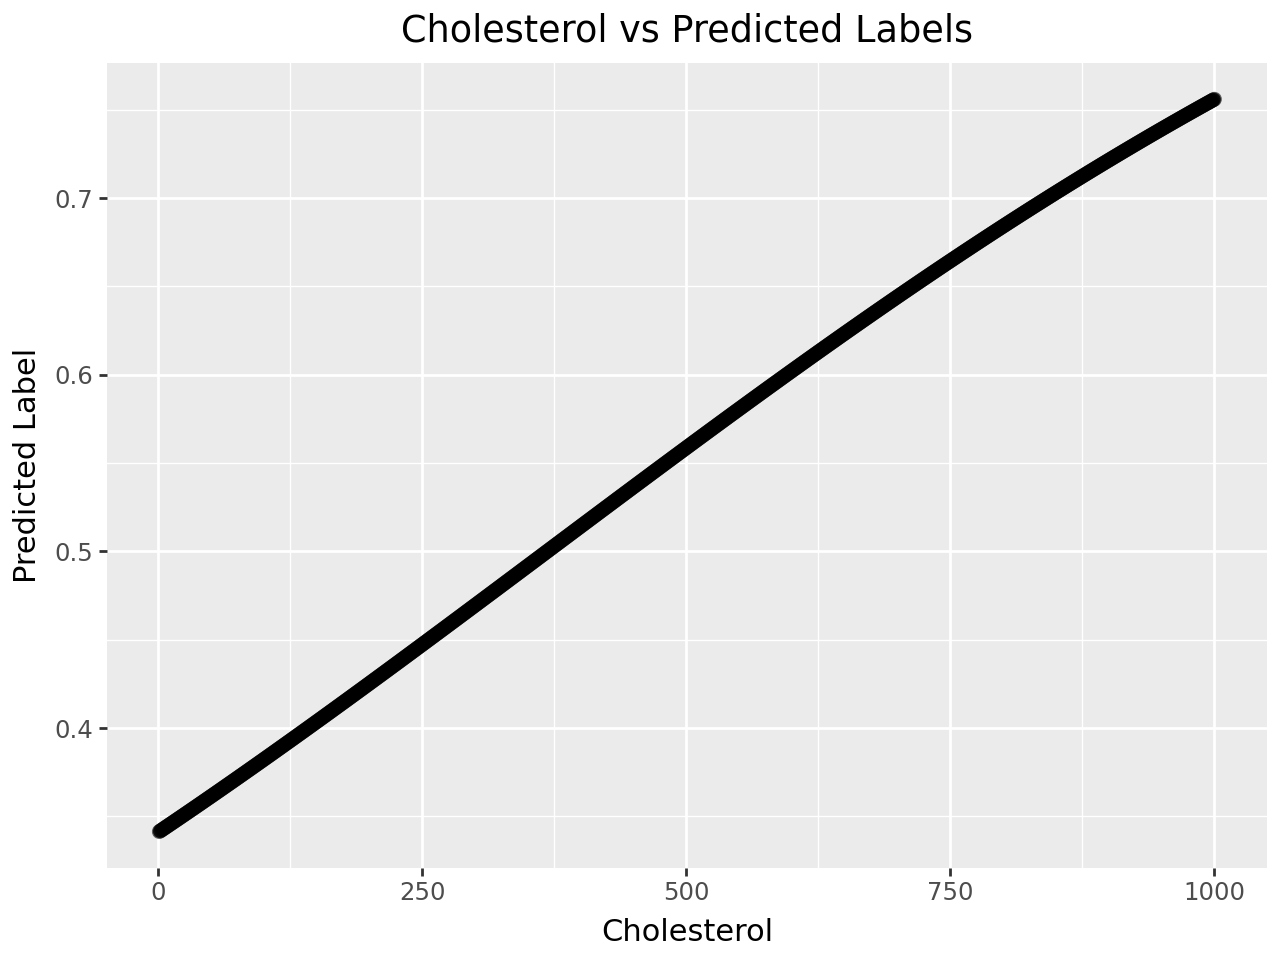

In [ ]:
(ggplot(dataT, aes(x='Cholesterol', y='Predicted_Label')) +
    geom_point(alpha=0.6, size=2) +
    labs(
        title="Cholesterol vs Predicted Labels",
        x="Cholesterol",
        y="Predicted Label"
    )
)

In [ ]:
threshold2 = 0.5
threshold2 = np.log(threshold2 / (1 - threshold2))
agec2	= 0.046557
cholc2 =	0.00179
age2=55

In [ ]:
val = (threshold2 - intercept2 - agec2 * 55) / cholc2
val

368.18025721054664

For a 55 yr old they would need a cholesterol reading over 375 ish


## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [ ]:
svc_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("svc", SVC(probability=True, kernel="linear"))
    ]
).set_output(transform="pandas")


param_grid = {'svc__C': [0.01, 0.1, 1, 10, 100]}

svc_grid = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring='roc_auc')

svc_grid.fit(X, y)
best_params = svc_grid.best_params_
print(f"Best parameters: {best_params}")


Best parameters: {'svc__C': 1}


In [ ]:
svc_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("svc", SVC(probability=True, kernel="linear", C=1))
    ]
).set_output(transform="pandas")

In [ ]:
svc_pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a1abd2fdf60>)])),
                ('svc', SVC(C=1, kernel='linear', probability=True))])

In [ ]:
y_pred = svc_pipeline.predict_proba(XT)[:, 1]

In [ ]:
dataT = pd.DataFrame({
    'Cholesterol': XT['chol'],
    'Predicted_Label': y_pred
})

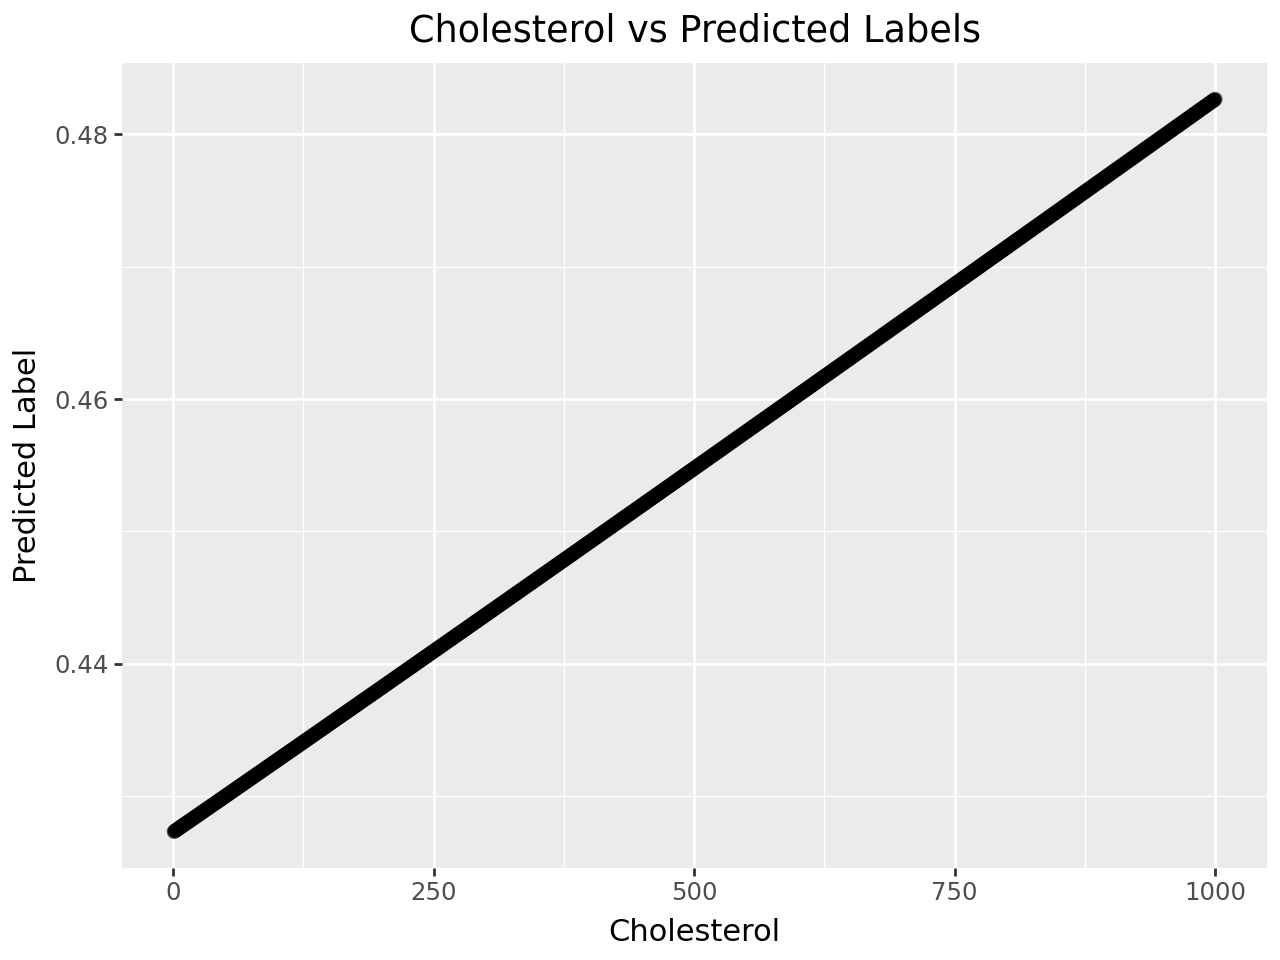

In [ ]:
(ggplot(dataT, aes(x='Cholesterol', y='Predicted_Label')) +
    geom_point(alpha=0.6, size=2) +
    labs(
        title="Cholesterol vs Predicted Labels",
        x="Cholesterol",
        y="Predicted Label"
    )
)

In [ ]:
svc_model = svc_pipeline.named_steps["svc"]
coef = svc_pipeline.named_steps['svc'].coef_
intercept3 = svc_model.intercept_[0]
coef

array([[0.06439772, 0.00365896]])

In [ ]:
threshold3 = 0.5
threshold3 = np.log(threshold3 / (1 - threshold3))
agec3	= 0.06439772
cholc3 =	0.00365896
age=55

In [ ]:
val = (threshold3 - intercept3 - agec3 * 55) / cholc3
val

312.70072786016885

For a 55 yr old they would need a cholesterol reading over 312 ish


## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

In [ ]:
val1 = (threshold3 - intercept3 - agec3 * 20) / cholc3
val2 = (threshold3 - intercept3 - agec3 * 55) / cholc3
val3 = (threshold3 - intercept3 - agec3 * 80) / cholc3

In [ ]:
dfsvc = pd.DataFrame({
    'age': [20, 55, 80],
    'values': [val1, val2, val3]
})

In [ ]:
val1 = (threshold2 - intercept2 - agec2 * 20) / cholc2
val2 = (threshold2 - intercept2 - agec2 * 55) / cholc2
val3 = (threshold2 - intercept2 - agec2 * 80) / cholc2

In [ ]:
dflda = pd.DataFrame({
    'age': [20, 55, 80],
    'values': [val1, val2, val3]
})

In [ ]:
val1 = (threshold - intercept - agec * 20) / cholc
val2 = (threshold - intercept - agec * 55) / cholc
val2 = (threshold - intercept - agec * 80) / cholc

In [ ]:
dflog = pd.DataFrame({
    'age': [20, 55, 80],
    'values': [val1, val2, val3]
})

In [ ]:
myData

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,1
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,0
2,Miles Wolf,62,0,3,130,263,1,97,1
3,Mikaila Block,43,1,1,115,303,1,181,0
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,0
...,...,...,...,...,...,...,...,...,...
199,Bridgett Franecki,55,0,1,128,205,2,130,1
200,Mr. Foster Zieme,51,1,3,94,227,1,154,0
201,Lashanda Hagenes,42,1,2,120,295,1,162,0
202,Levern Trantow III,35,0,1,138,183,1,182,0


In [ ]:
myData['diagnosis'] = myData['diagnosis'].astype('category')


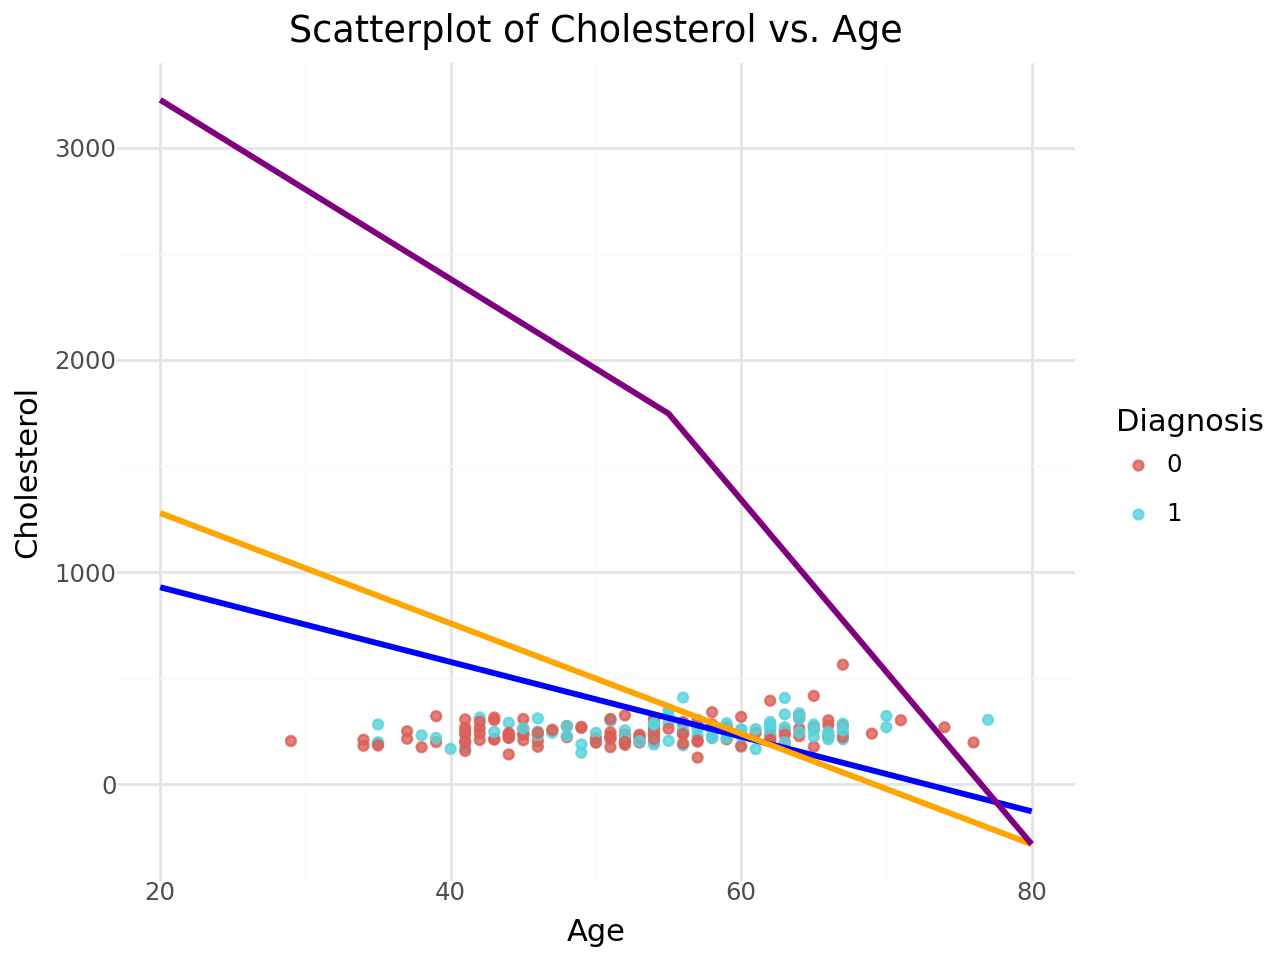

In [ ]:
(ggplot() +
    geom_point(myData, aes(x='age', y='chol', color='diagnosis'), alpha=0.8) +
    geom_line(aes(x='age', y='values'), data=dfsvc, size=1.2, color='blue') +
    geom_line(aes(x='age', y='values'), data=dflda, size=1.2, color='orange') +
    geom_line(aes(x='age', y='values'), data=dflog, size=1.2, color='purple') +
    labs(
        title='Scatterplot of Cholesterol vs. Age',
        x='Age',
        y='Cholesterol',
        color='Diagnosis'
    ) +
    theme_minimal()
)

Logistic regression is purple, LDA is orange, and SVC is blue